## Testing of trained models

### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *
from online_tracker import OnlineTracker

### Helper methods

In [2]:
def get_default_settings(model_name): #the settings all models are trained on
    scale = 4
    wall_amount = 100*scale
    food_amount = 500*scale
    centered_env = Centered_Env(food_amount=food_amount, wall_amount=wall_amount//4)
    cluster_env = Cluster_Env(clusters=30*scale, cluster_size=30, wall_amount=wall_amount//4)
    circle_env = Circle_Env(circles=2*scale, food_amount=food_amount*2, wall_amount=wall_amount*2)
    spiral_env = Spiral_Env(spirals=3, food_amount=food_amount, wall_amount=wall_amount)

    train_config = Train_Config(stdev=0.1, popsize=10, 
        name=model_name, problem_searcher=ProblemSearcher.CMAES,
        with_samplepool=False, timesteps=1000)

    settings = Settings(
        device = torch.device('cpu'),
        batch_size = 2,
        n = 100,
        food_envs=[centered_env, cluster_env, circle_env, spiral_env],
        scale = scale,
        wrap_around = False,
        
        model_type = ModelType.LocalOnly,
        #model_type = ModelType.WithGlobalNode,
        #model_type = ModelType.SmallWorld,

        radius = 0.04,
        radius_food_scale = 5,
        consume_radius_scale = 3/4, 
        consumption_edge_required = 3,
        noise = 0.002,
        energy_required_to_replicate = 30,
        train_config=train_config,

        radius_wall_scale = 5,
        radius_wall_damage_scale = 2,
        wall_damage = 10,

        radius_long_scale=2,
    )
    return settings

In [3]:
def load_model(settings):
    model = Conv(settings=settings)
    model.load_state_dict(torch.load('../models/' + settings.train_config.name + '.pth'))
    return model

In [4]:
#Helper method for running a given model and setting config on each env type x times
def test_model(model, settings, times):
    score_dict = {}

    for food_env in settings.food_envs:
        score_dict[food_env.env_type] = []
        for _ in range(times//2): #batch size 2
            graphs = [generate_organism(settings).toGraph(food_env) for _ in range(settings.batch_size)]
            loader = DataLoader(graphs, batch_size=settings.batch_size)
            graph = next(iter(loader))
            with torch.no_grad():
                graph = model(graph, settings.train_config.timesteps)
            score_dict[food_env.env_type].extend(graph.food_reward.detach().numpy())
    return score_dict

In [5]:
#Helper method for doing analysis on the results 
#?

In [6]:
#Helper method for plotting these results 
#maybe histplot/barplot with each model/env combo in each bar with average and best... at y
#show all models at each bar for each env so its easy to compare which models performs best on which envs

### Test models on trained env

In [7]:
#settings = get_default_settings('hidden15')
settings = get_default_settings('hidden18_local')
model = load_model(settings)

score_dict = test_model(model, settings, 10)
score_dict

{<EnvironmentType.Centered: (1,)>: [400.0,
  426.0,
  422.0,
  362.0,
  345.0,
  361.0,
  414.0,
  422.0,
  339.0,
  387.0],
 <EnvironmentType.Clusters: (2,)>: [550.0,
  58.0,
  19.0,
  1017.0,
  61.0,
  11.0,
  53.0,
  6.0,
  2.0,
  317.0],
 <EnvironmentType.Circular: (3,)>: [191.0,
  186.0,
  327.0,
  378.0,
  288.0,
  426.0,
  358.0,
  375.0,
  349.0,
  398.0],
 <EnvironmentType.Spiral: (4,)>: [0.0,
  19.0,
  20.0,
  0.0,
  55.0,
  20.0,
  3.0,
  31.0,
  50.0,
  1.0]}

### Setup all testing options

In [8]:
#length of radius for edges
#amount of random noise
#graph size
#edges randomly cut
#nodes randomly removed
noise_options = [0.0, 0.002, 0.004, 0.008]
#noise in random nodes hidden states


In [9]:
#update settings and everything to work with this
#create new visualizer

### Test on specified options

In [13]:
#TODO somehow ensure we hardcoded test on one of each environment
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
model(graph, 0)

DataBatch(x=[7100, 11], edge_index=[1, 0], device=[2], subsize=[2], velocity=[2], border_cost=[2], food_reward=[2], dead_cost=[2], visible_food=[2], food_avg_dist=[2], food_avg_degree=[2], food_search_movement=[2], cells_alive=[2], batch=[7100], ptr=[3])

### Visualize 

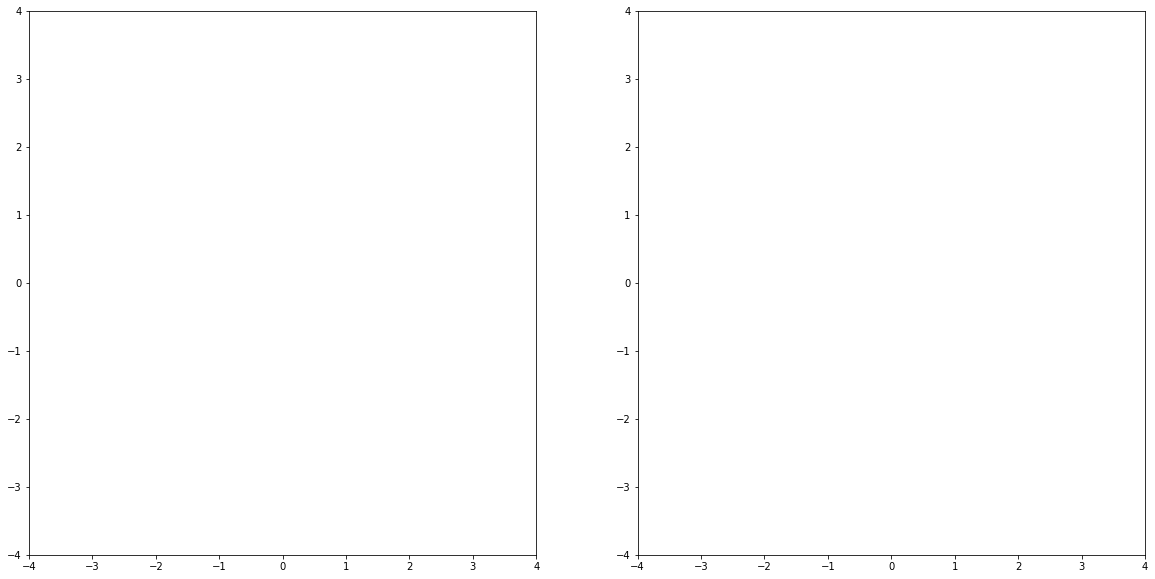

In [14]:
dpi = 100 #beautiful
#dpi = 50 #fast

anim = visualizer.animate_organism(graph, model) 
visualizer.save_animation_to_gif(anim, settings.train_config.name + '_test', fps=10, dpi=dpi)

In [ ]:
Image('../animation/' + settings.train_config.name + '_test.gif')

FileNotFoundError: No such file or directory: '../animation/hidden18_local_test.gif'

FileNotFoundError: No such file or directory: '../animation/hidden18_local_test.gif'

<IPython.core.display.Image object>

### Plot average of performance on different settings for each mode type

perform x tests on each configuration for each mode and see which performs best in each and across each config

In [ ]:
#